In [27]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import Callback

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn import metrics

from time import time

In [2]:
%%time
PATH_STORE = '../saved/storage.h5'
train_pd = pd.read_hdf(PATH_STORE, 'train')


CPU times: user 133 ms, sys: 2.03 s, total: 2.17 s
Wall time: 1min 3s


In [15]:
import random
rows = random.sample(train_pd.index, 10000)
df = train_pd.ix[rows]
df.fillna(0, inplace=True)

In [136]:
from keras.layers.advanced_activations import ParametricSoftplus, PReLU
from keras.optimizers import Adadelta, Adagrad, Adam, RMSprop
def build_model(input_dim, output_dim):
    size_hid = 1024*1
    
    model = Sequential()
    model.add(Dense(input_dim, size_hid, init='lecun_uniform'))
#     model.add(Activation('relu'))
    model.add(ParametricSoftplus(size_hid))
    model.add(Dropout(0.5))

    model.add(Dense(size_hid, size_hid, init='lecun_uniform'))
#     model.add(Activation('relu'))
    model.add(ParametricSoftplus(size_hid))
    model.add(Dropout(0.5))
    
    model.add(Dense(size_hid, size_hid, init='lecun_uniform'))
#     model.add(Activation('relu'))
    model.add(ParametricSoftplus(size_hid))
    model.add(Dropout(0.5))
    
    model.add(Dense(size_hid, size_hid, init='lecun_uniform'))
#     model.add(Activation('relu'))
    model.add(ParametricSoftplus(size_hid))
    model.add(Dropout(0.5))

    model.add(Dense(size_hid, output_dim, init='lecun_uniform'))
    model.add(Activation('softmax'))

    opt = RMSprop(lr=0.0005, rho=0.75, epsilon=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [125]:
%%time
y = df['target']
Y = np_utils.to_categorical(y)
df.drop(['target'], axis=1, inplace=True)
X = np.array(df)
X = X.astype(np.float32)

scaler = StandardScaler()
X = scaler.fit_transform(X)


CPU times: user 1.73 s, sys: 470 ms, total: 2.2 s
Wall time: 2.16 s


In [132]:
# X = X[:, X.max(axis=0) < 1]
print X.shape

(10000, 2152)


In [137]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))

In [138]:
input_dim = X.shape[1]
output_dim = Y.shape[1]

k = 4
skf = StratifiedKFold(y, n_folds=k,)
scores = []
losses = []
f = 0
for train, valid in skf:
    tic = time()
    print('---'*20)
    print('Fold', f)
    print('---'*20)
    f += 1
    X_train = X[train]
    X_valid = X[valid]
    Y_train = Y[train]
    Y_valid = Y[valid]
    y_valid = np.array(y)[valid]
    
    history = LossHistory()

    print("Building model...")
    model = build_model(input_dim, output_dim)

    print("Training model...")

    model.fit(X_train, Y_train, nb_epoch=100, batch_size=1024*4, 
              validation_data=(X_valid, Y_valid),
              callbacks=[history],
              verbose=2)
    valid_preds = model.predict_proba(X_valid, batch_size=1024*16, verbose=0)
    valid_preds = valid_preds[:, 1]
    roc = metrics.roc_auc_score(y_valid, valid_preds)
    print("ROC:", roc)
    
    scores.append(roc)
    losses.append(history.losses)
    
    toc = time() - tic
    print 'Time: %g sec' % toc

print('Average ROC:', np.mean(scores))


------------------------------------------------------------
('Fold', 0)
------------------------------------------------------------
Building model...
Training model...
Train on 7499 samples, validate on 2501 samples
Epoch 0
0s - loss: 0.6460 - val_loss: 0.5828
Epoch 1
0s - loss: 0.5738 - val_loss: 0.5593
Epoch 2
0s - loss: 0.5573 - val_loss: 0.5513
Epoch 3
0s - loss: 0.5524 - val_loss: 0.5485
Epoch 4
0s - loss: 0.5514 - val_loss: 0.5471
Epoch 5
0s - loss: 0.5514 - val_loss: 0.5461
Epoch 6
0s - loss: 0.5494 - val_loss: 0.5454
Epoch 7
0s - loss: 0.5478 - val_loss: 0.5446
Epoch 8
0s - loss: 0.5473 - val_loss: 0.5448
Epoch 9
0s - loss: 0.5487 - val_loss: 0.5436
Epoch 10
0s - loss: 0.5478 - val_loss: 0.5435
Epoch 11
0s - loss: 0.5466 - val_loss: 0.5432
Epoch 12
0s - loss: 0.5444 - val_loss: 0.5434
Epoch 13
0s - loss: 0.5461 - val_loss: 0.5432
Epoch 14
0s - loss: 0.5456 - val_loss: 0.5417
Epoch 15
0s - loss: 0.5435 - val_loss: 0.5424
Epoch 16
0s - loss: 0.5442 - val_loss: 0.5409
Epoch 17
0

0.72832446344
[ 0.72455823  0.73844815  0.71476646  0.73552501]


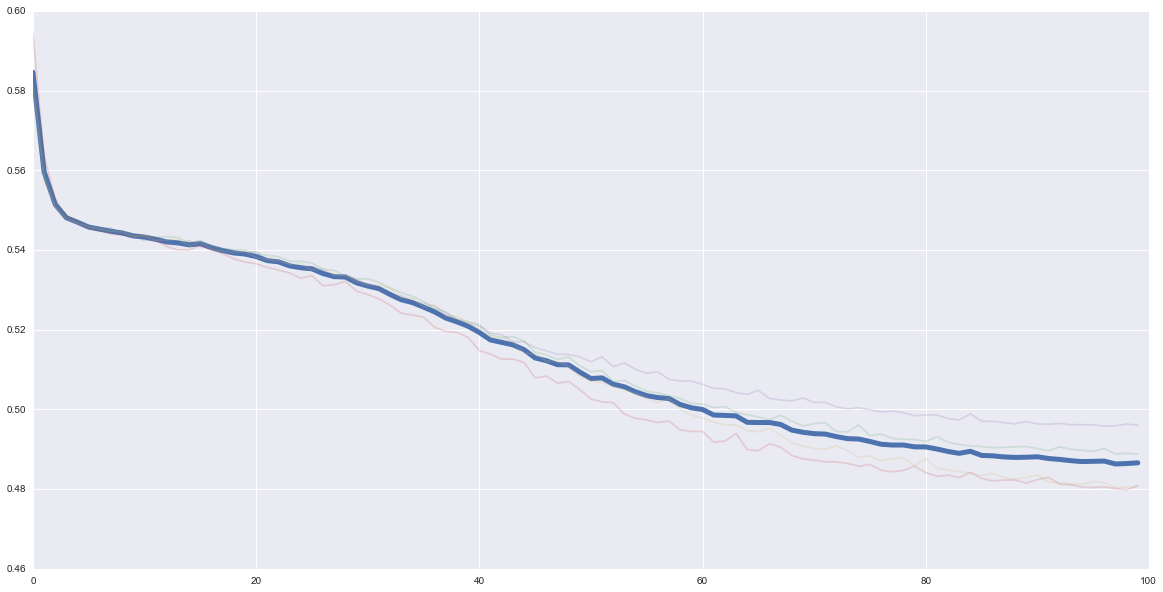

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(20,10));
print np.array(scores).mean()
print np.array(scores)
plt.plot(np.mean(losses, axis=0), lw=5);
plt.plot(np.array(losses).T, alpha=0.2);